## Importing libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from pmdarima.arima import ARIMA,auto_arima
from matplotlib.pyplot import vlines
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing

## Loading the data

In [2]:
df = pd.read_csv('avocado.csv')

In [3]:
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [4]:
df.drop("Unnamed: 0",axis=1,inplace=True)

### Creating revenue column and setting date as index

In [5]:
df['Revenue'] = df['AveragePrice'] * df['Total Volume']

In [6]:
df1 = df.groupby('Date')['Revenue'].sum().reset_index().copy()

In [7]:
df1['Date'].dtypes

dtype('O')

In [8]:
df1['Date'] = pd.to_datetime(df1['Date'])

In [9]:
df1.sort_values("Date", inplace = True)

In [10]:
df1.set_index('Date', inplace=True) 

In [11]:
df1.index.min()

Timestamp('2015-01-04 00:00:00')

In [12]:
df1.index.max()

Timestamp('2018-03-25 00:00:00')

In [13]:
df1.isna().sum()

Revenue    0
dtype: int64

In [14]:
df2 = df1['Revenue'].resample('W').mean()

In [15]:
df2.shape

(169,)

In [16]:
df2.isna().sum()

0

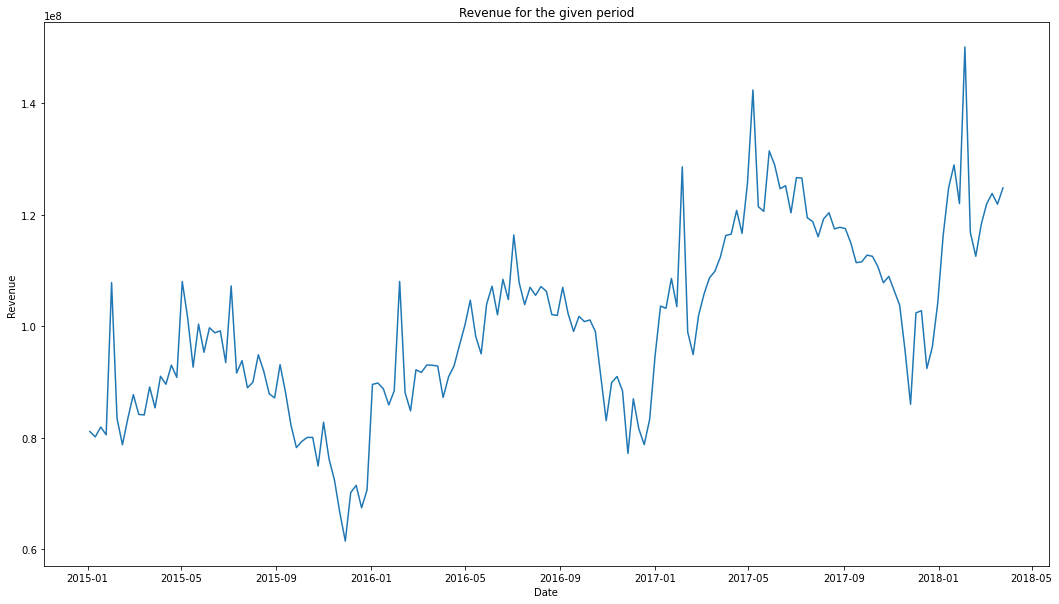

In [17]:
plt.figure(figsize=(18,10))
plt.title('Revenue for the given period')
sns.lineplot(data = df2)
plt.show()

**I can notice that data is nonstationary with little upward trend and there is also some seasonal componenet attached to it**

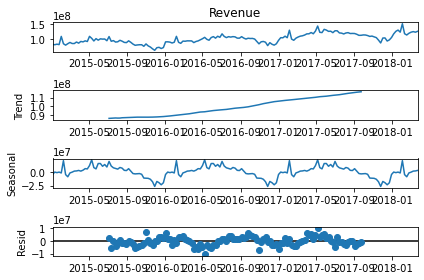

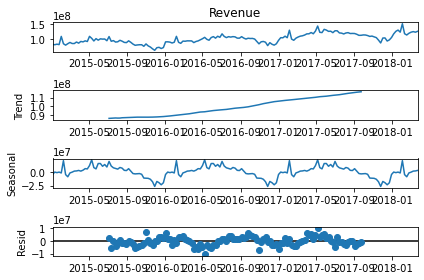

In [18]:
Decomposed_Series = seasonal_decompose(df2,model='additive')
Decomposed_Series.plot()

### Stationarity check

In [19]:
def test_stationarity(data):
    
    # Determining rolling statistics
    movingAvg = data.rolling(window=12).mean()
    movingStd = data.rolling(window=12).std()
    
    # Plotting
    orig = plt.plot(data,color='blue',label='original')
    mean = plt.plot(movingAvg,color='red',label='Rolling Mean')
    std = plt.plot(movingStd,color='black',label='Rolling Std')
    plt.legend(loc='best')
    plt.title("Rolling Mean and Standard deviation")
    plt.show()
    
    # ADF Test
    dftest = adfuller(data,autolag='AIC')
    dfoutput = pd.Series(dftest[0:4],index=['Test Statistics','p-value','#lags used','Number of observation used'])
    print(dfoutput)
    if dfoutput[1] > 0.05:
        print('\nData is nonstationary')
    else:
        print('\nData is stationary')

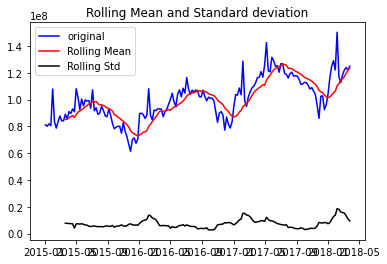

Test Statistics                -1.615951
p-value                         0.474853
#lags used                     13.000000
Number of observation used    155.000000
dtype: float64

Data is nonstationary


In [20]:
test_stationarity(df2)

## Split in test and train in exactly 80 and 20 % 

In [21]:
size=int(len(df2)*0.8)

In [22]:
Train = df2.iloc[:size]  # 80 %

In [24]:
Test=df2.iloc[size:] # 20 %
Test.shape

(34,)

### Function for plotting and validating

In [24]:
def PlotValidation(model):
    Forecast = model.forecast(34).rename('Forecast') # Model Forecasting
    # Act, Forecast combining
    Actual_Forecast_Df = pd.concat([df2, Forecast], axis = 1) 
    # Plot
    plt.figure(figsize=(18,10))
    sns.lineplot(data = Actual_Forecast_Df)
    plt.show()
    ## Validation
    Validation_Df = Actual_Forecast_Df[-34:].copy()
    print("MAPE",np.mean(abs(Validation_Df['Revenue'] - Validation_Df['Forecast'])/Validation_Df['Revenue'])*100) # MAPE
    print("RMSE",np.sqrt(np.mean((Validation_Df['Revenue'] - Validation_Df['Forecast'])**2))) #RMSE

## Simple Exponential Smoothing (SES)

In [32]:
SES = SimpleExpSmoothing(Train).fit()

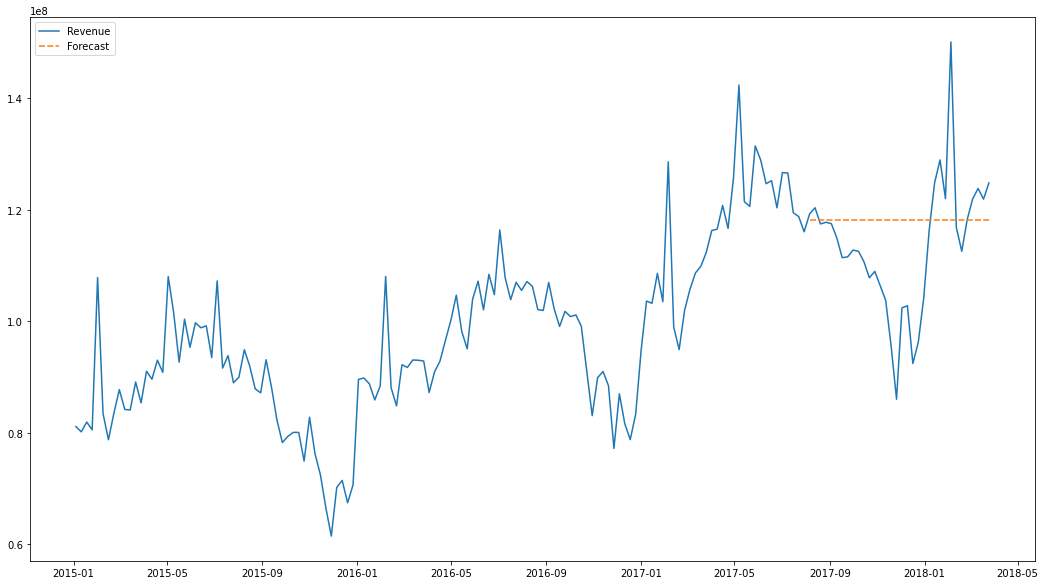

MAPE 8.697226261965463
RMSE 12674832.042264592


In [33]:
PlotValidation(SES)

## Double Exponential Smoothing (DES)

In [34]:
DES = Holt(Train).fit(smoothing_level=0.001, smoothing_slope=0.001)

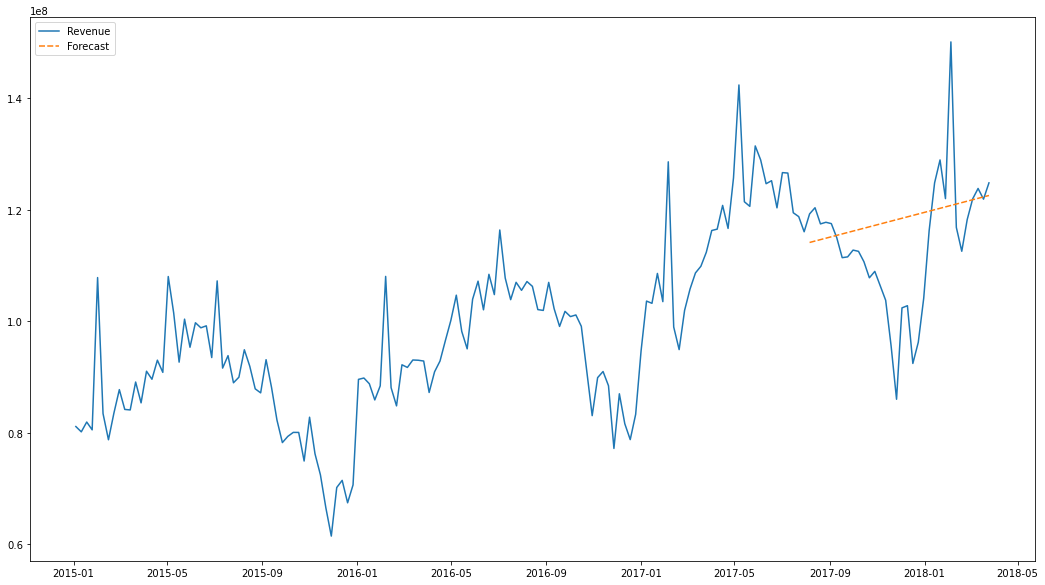

MAPE 8.471502259308002
RMSE 12453302.599412346


In [35]:
PlotValidation(DES)

## Triple Exponential Smoothing (TES)

In [36]:
TES = ExponentialSmoothing(Train,  
                           seasonal='add',
                           trend = 'add').fit(smoothing_level = 0.2, 
                                              smoothing_slope = 0.0001, 
                                              smoothing_seasonal = 0.02)

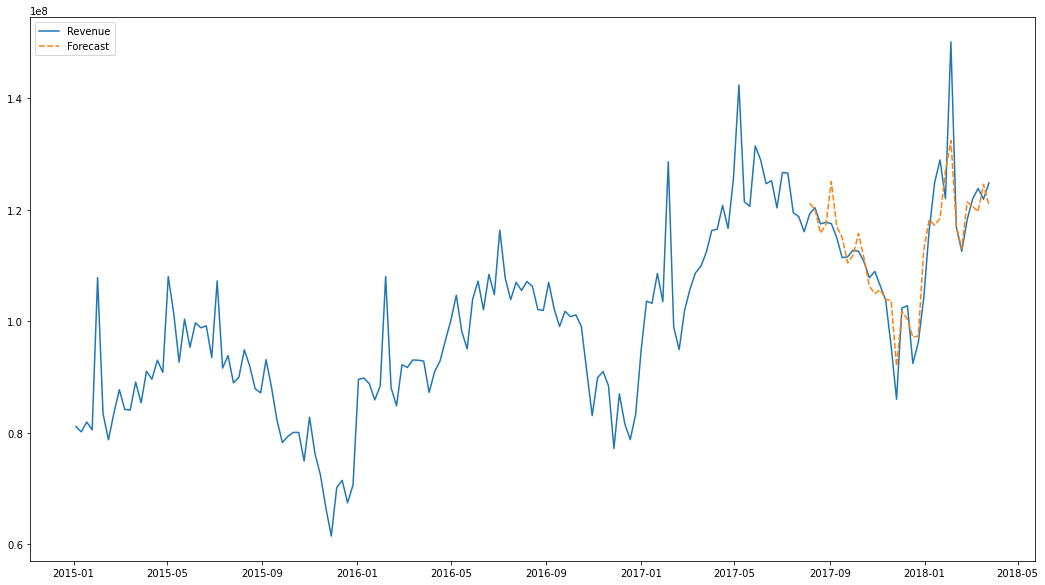

MAPE 3.0602915659696555
RMSE 5086682.631415832


In [37]:
PlotValidation(TES)

#### Searching for the best TES model

In [155]:
myAlpha = np.round(np.arange(0,1.1,0.1),2)
myBeta = np.round(np.arange(0,1.1,0.1),2)
myGamma = np.round(np.arange(0,1.1,0.1),2)

alphaList = []
betaList = []
gammaList = []
mapeList = []

for alpha in myAlpha:
    for beta in myBeta:
        for gamma in myGamma:
            
            print(alpha, beta, gamma)
                                              
            TES = ExponentialSmoothing(Train, 
                           seasonal='add', # seasonal='add'
                           trend = 'add').fit(smoothing_level = alpha, 
                                      smoothing_slope = beta, 
                                      smoothing_seasonal = gamma)
            
            Forecast = TES.forecast(34).rename('Forecast')
            Actual_Forecast_Df = pd.concat([df2, Forecast], axis = 1)
            Validation_Df = Actual_Forecast_Df[-34:].copy()
            tempMAPE = np.mean(abs(Validation_Df['Revenue'] - Validation_Df['Forecast'])/Validation_Df['Revenue'])*100 # MAPE
            
            
            alphaList.append(alpha)
            betaList.append(beta)
            gammaList.append(gamma)
            mapeList.append(tempMAPE)
            
            
evaluationDf = pd.DataFrame({"alpha": alphaList,
                             "beta": betaList,
                             "gamma": gammaList,
                             "MAPE": mapeList})        
            
evaluationDf.to_csv("EvaluationDf.csv")

0.0 0.0 0.0
0.0 0.0 0.1
0.0 0.0 0.2
0.0 0.0 0.3
0.0 0.0 0.4
0.0 0.0 0.5
0.0 0.0 0.6
0.0 0.0 0.7
0.0 0.0 0.8
0.0 0.0 0.9
0.0 0.0 1.0
0.0 0.1 0.0
0.0 0.1 0.1
0.0 0.1 0.2
0.0 0.1 0.3
0.0 0.1 0.4
0.0 0.1 0.5
0.0 0.1 0.6
0.0 0.1 0.7
0.0 0.1 0.8
0.0 0.1 0.9
0.0 0.1 1.0
0.0 0.2 0.0
0.0 0.2 0.1
0.0 0.2 0.2
0.0 0.2 0.3
0.0 0.2 0.4
0.0 0.2 0.5
0.0 0.2 0.6
0.0 0.2 0.7
0.0 0.2 0.8
0.0 0.2 0.9
0.0 0.2 1.0
0.0 0.3 0.0
0.0 0.3 0.1
0.0 0.3 0.2
0.0 0.3 0.3
0.0 0.3 0.4
0.0 0.3 0.5
0.0 0.3 0.6
0.0 0.3 0.7
0.0 0.3 0.8
0.0 0.3 0.9
0.0 0.3 1.0
0.0 0.4 0.0
0.0 0.4 0.1
0.0 0.4 0.2
0.0 0.4 0.3
0.0 0.4 0.4
0.0 0.4 0.5
0.0 0.4 0.6
0.0 0.4 0.7
0.0 0.4 0.8
0.0 0.4 0.9
0.0 0.4 1.0
0.0 0.5 0.0
0.0 0.5 0.1
0.0 0.5 0.2
0.0 0.5 0.3
0.0 0.5 0.4
0.0 0.5 0.5
0.0 0.5 0.6
0.0 0.5 0.7
0.0 0.5 0.8
0.0 0.5 0.9
0.0 0.5 1.0
0.0 0.6 0.0
0.0 0.6 0.1
0.0 0.6 0.2
0.0 0.6 0.3
0.0 0.6 0.4
0.0 0.6 0.5
0.0 0.6 0.6
0.0 0.6 0.7
0.0 0.6 0.8
0.0 0.6 0.9
0.0 0.6 1.0
0.0 0.7 0.0
0.0 0.7 0.1
0.0 0.7 0.2
0.0 0.7 0.3
0.0 0.7 0.4
0.0 0.7 0.5
0.0 

0.5 0.7 0.3
0.5 0.7 0.4
0.5 0.7 0.5
0.5 0.7 0.6
0.5 0.7 0.7
0.5 0.7 0.8
0.5 0.7 0.9
0.5 0.7 1.0
0.5 0.8 0.0
0.5 0.8 0.1
0.5 0.8 0.2
0.5 0.8 0.3
0.5 0.8 0.4
0.5 0.8 0.5
0.5 0.8 0.6
0.5 0.8 0.7
0.5 0.8 0.8
0.5 0.8 0.9
0.5 0.8 1.0
0.5 0.9 0.0
0.5 0.9 0.1
0.5 0.9 0.2
0.5 0.9 0.3
0.5 0.9 0.4
0.5 0.9 0.5
0.5 0.9 0.6
0.5 0.9 0.7
0.5 0.9 0.8
0.5 0.9 0.9
0.5 0.9 1.0
0.5 1.0 0.0
0.5 1.0 0.1
0.5 1.0 0.2
0.5 1.0 0.3
0.5 1.0 0.4
0.5 1.0 0.5
0.5 1.0 0.6
0.5 1.0 0.7
0.5 1.0 0.8
0.5 1.0 0.9
0.5 1.0 1.0
0.6 0.0 0.0
0.6 0.0 0.1
0.6 0.0 0.2
0.6 0.0 0.3
0.6 0.0 0.4
0.6 0.0 0.5
0.6 0.0 0.6
0.6 0.0 0.7
0.6 0.0 0.8
0.6 0.0 0.9
0.6 0.0 1.0
0.6 0.1 0.0
0.6 0.1 0.1
0.6 0.1 0.2
0.6 0.1 0.3
0.6 0.1 0.4
0.6 0.1 0.5
0.6 0.1 0.6
0.6 0.1 0.7
0.6 0.1 0.8
0.6 0.1 0.9
0.6 0.1 1.0
0.6 0.2 0.0
0.6 0.2 0.1
0.6 0.2 0.2
0.6 0.2 0.3
0.6 0.2 0.4
0.6 0.2 0.5
0.6 0.2 0.6
0.6 0.2 0.7
0.6 0.2 0.8
0.6 0.2 0.9
0.6 0.2 1.0
0.6 0.3 0.0
0.6 0.3 0.1
0.6 0.3 0.2
0.6 0.3 0.3
0.6 0.3 0.4
0.6 0.3 0.5
0.6 0.3 0.6
0.6 0.3 0.7
0.6 0.3 0.8
0.6 

In [38]:
Final_TES = ExponentialSmoothing(Train,seasonal_periods=52, seasonal='add',trend = 'add').fit(smoothing_level = 0.1, 
                                                                                              smoothing_slope = 0,
                                                                                              smoothing_seasonal = 0.5)

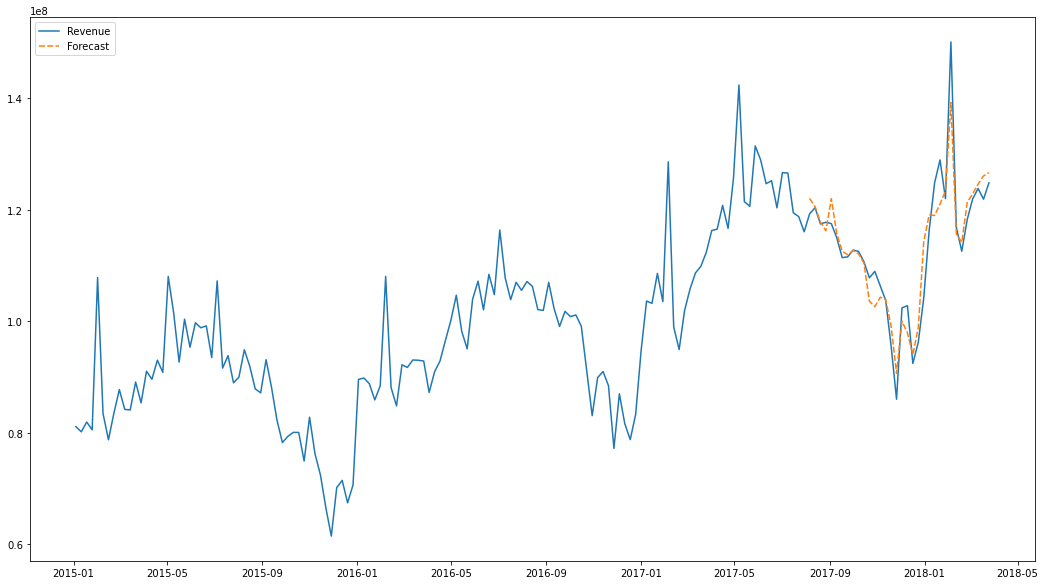

MAPE 2.5203662633897195
RMSE 3953085.018792724


In [39]:
PlotValidation(Final_TES)

## ARIMA MODEL

In [58]:
arimaModel = ARIMA((4,1,3), (1,0,0,52)).fit(Train)
Forecast = pd.Series(arimaModel.predict(34)).rename('Forecast')

In [59]:
Forecast.index = Test.index

In [60]:
Actual_Forecast_Df = pd.concat([df2, Forecast], axis = 1)

MAPE 5.927627983441233
RMSE 8959904.722238692


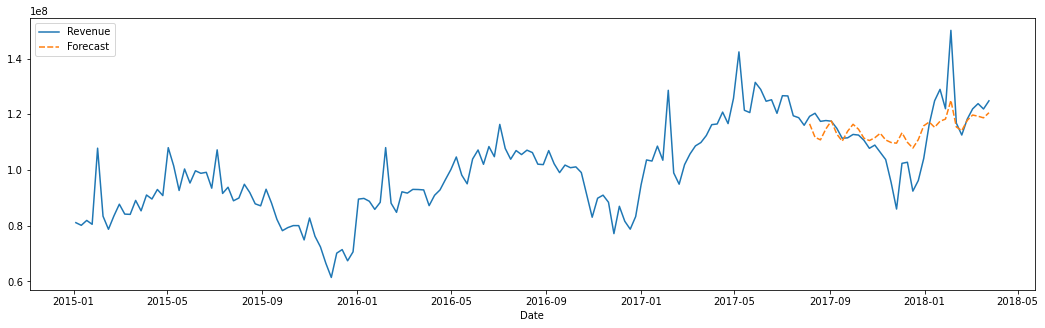

In [61]:
Validation_Df = Actual_Forecast_Df[-34:].copy()
print("MAPE",np.mean(abs(Validation_Df['Revenue'] - Validation_Df['Forecast'])/Validation_Df['Revenue'])*100) # MAPE
print("RMSE",np.sqrt(np.mean((Validation_Df['Revenue'] - Validation_Df['Forecast'])**2))) # RMSE

# Plot
import seaborn as sns
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
plt.show()

**Since the MAPE of Final_TES is least so i am selecting this as my final model.**

## Forecasting with finalized model

In [62]:
Final_TES2 = ExponentialSmoothing(df2,seasonal_periods=52, seasonal='add',trend = 'add').fit(smoothing_level = 0.1, 
                                                                                              smoothing_slope = 0,
                                                                                              smoothing_seasonal = 0.5)

In [69]:
## Forecasting
Forecast = pd.Series(Final_TES2.predict(100)).rename('Forecast')

In [70]:
# Set the correct dates as index of the forecast obtained in the previous line
start = "2018-04-01" 
end = "2019-07-25"
futureDateRange = pd.date_range(start, end, freq='W')

In [71]:
Forecast.index =  futureDateRange 

In [72]:
Actual_Forecast_Df = pd.concat([df2, Forecast], axis = 1) # Column wise binding

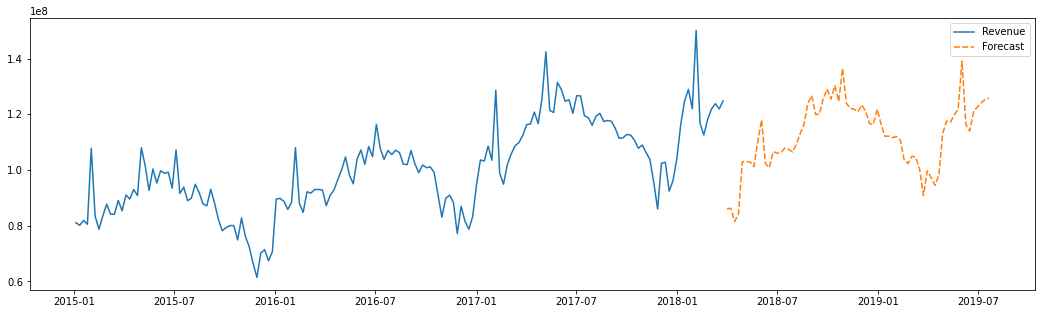

In [73]:
## Plot
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Df)
plt.show()

## Actual and forecasted values separated by red line

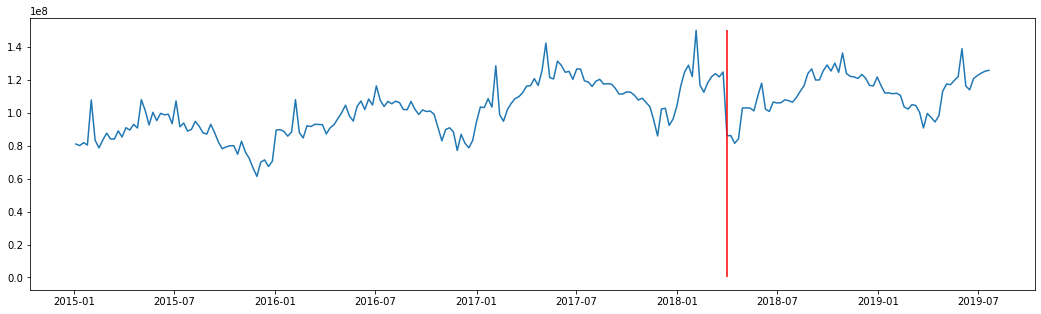

In [74]:
Actual_Forecast_Series = pd.concat([df2, Forecast], axis = 0) # Row wise binding
plt.figure(figsize=(18,5))
sns.lineplot(data = Actual_Forecast_Series)
vlines(x = Actual_Forecast_Series.index[169],ymin=0,ymax = max(Actual_Forecast_Series), colors = "red")
plt.show()